# Testing the Data

In [ ]:
model = keras.models.load_model('/kaggle/input/spoofdetector/tensorflow2/default/1/audio_cnn.h5')

In [385]:
def save_mfcc_test(dataset_path, json_path, num_mfcc=13, n_fft=1024, hop_length=512, num_segments=5):

    MAX_SAMPLES = SAMPLES_PER_TRACK
    
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        if dirpath is not dataset_path:

            
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

           
            for f in filenames:

                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                
                for d in range(num_segments):
                    
                    start = samples_per_segment * d
                    finish = start + samples_per_segment
                    
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [386]:
#save_mfcc_test(TEST_DATASET_PATH, TEST_JSON_PATH, num_segments=2)

In [387]:
test_loss, test_acc, test_recall = model.evaluate(TestX, TestY, verbose=2)
print('\nTest accuracy:', test_acc)

502/502 - 2s - 4ms/step - accuracy: 0.8104 - loss: 0.7059 - recall_35: 0.6716

Test accuracy: 0.810438334941864


In [388]:
y_pred_probs = model.predict(X_validation)  # shape: (num_samples,)

# Compute FPR, TPR, thresholds
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_probs)
fnr = 1 - tpr  # False Negative Rate

# Find the point where FPR and FNR are closest
eer_threshold_index = np.nanargmin(np.abs(fpr - fnr))
eer = (fpr[eer_threshold_index] + fnr[eer_threshold_index]) / 2
eer_threshold = thresholds[eer_threshold_index]

print(f"Equal Error Rate (EER): {eer:.4f}")
print(f"EER Threshold: {eer_threshold:.4f}")


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Equal Error Rate (EER): 0.0568
EER Threshold: 0.4104


502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


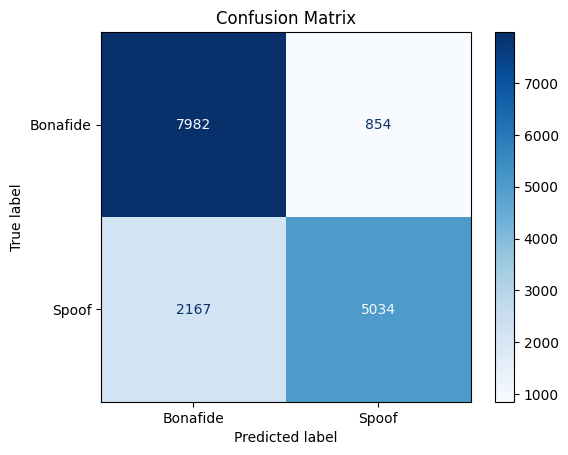

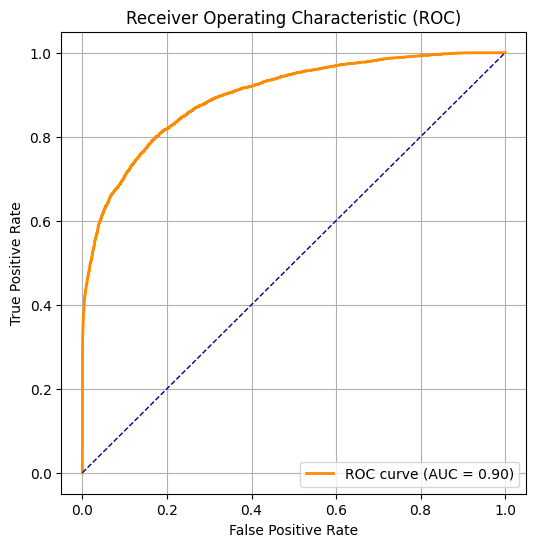

AUC Score: 0.8978


In [389]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns


y_pred_probs = model.predict(TestX) 
threshold = 0.5
y_pred = (y_pred_probs >= eer_threshold).astype(int)

# 4️⃣ Confusion Matrix
cm = confusion_matrix(TestY, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bonafide", "Spoof"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# 5️⃣ ROC Curve and AUC Score
fpr, tpr, _ = roc_curve(TestY, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"AUC Score: {roc_auc_score(TestY, y_pred_probs):.4f}")

In [390]:
# Compute FPR, TPR, thresholds
fpr, tpr, thresholds = roc_curve(TestY, y_pred_probs)
fnr = 1 - tpr  # False Negative Rate

# Find the point where FPR and FNR are closest
eer_threshold_index = np.nanargmin(np.abs(fpr - fnr))
eer = (fpr[eer_threshold_index] + fnr[eer_threshold_index]) / 2
eer_threshold = thresholds[eer_threshold_index]

print(f"Equal Error Rate (EER): {eer:.4f}")
print(f"EER Threshold: {eer_threshold:.4f}")

from sklearn.metrics import f1_score

# Use thresholded predictions
f1 = f1_score(TestY, y_pred)  # or y_pred_eer if using EER threshold

print(f"F1 Score: {f1:.4f}")

Equal Error Rate (EER): 0.1881
EER Threshold: 0.0931
F1 Score: 0.7692


In [ ]:
def test_file(model, file_path, num_mfcc=13, n_fft=1024, hop_length=512, num_segments=2, eer_threshold=0.37):
    SAMPLE_RATE = 16000
    
    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
    signal_length = len(signal)

    segment_samples = int(signal_length / num_segments)
    if segment_samples < hop_length:
        raise ValueError("Segment too short for MFCC extraction. Reduce num_segments or increase audio length.")

    predictions = []
    vote_counts = {0: 0, 1: 0}

    for d in range(num_segments):
        start = segment_samples * d
        finish = start + segment_samples
        if finish > len(signal):
            finish = len(signal)

        mfcc = librosa.feature.mfcc(
            y=signal[start:finish],
            sr=sample_rate,
            n_mfcc=num_mfcc,
            n_fft=n_fft,
            hop_length=hop_length
        ).T

        if len(mfcc) < 63:
            mfcc = np.pad(mfcc, ((0, 63 - len(mfcc)), (0, 0)), mode='constant')
        else:
            mfcc = mfcc[:63, :]

        mfcc = np.expand_dims(mfcc, axis=-1)  # (63, num_mfcc, 1)
        mfcc = np.expand_dims(mfcc, axis=0)   # (1, 63, num_mfcc, 1)

        prob = model.predict(mfcc, verbose=0)[0][0]
        predictions.append(prob)

        label = int(prob >= eer_threshold)
        vote_counts[label] += 1

    if len(predictions) == 0:
        return -1, -1

    avg_prob = np.mean(predictions)
    if vote_counts[1] == vote_counts[0]:
        return avg_prob, int(avg_prob >= eer_threshold)
    elif vote_counts[1] > vote_counts[0]:
        return avg_prob, 1
    else:
        return avg_prob, 0


In [ ]:
_, pred = test_file(model, '/kaggle/input/testaudio.wav')